# Data Science template - Titanic Case

Deze notebook begeleidt je stap voor stap door de **Titanic**-case op Kaggle.
De focus ligt op de standaard Data Science workflow:

1. Probleemdefinitie en doel
2. Data-input & Data cleaning
3. Verkenning (EDA)
4. Feature engineering
5. Modelleren (baseline → verbeterde modellen)
6. **Voorspelling** en export van `submission.csv`

> 🎯 Doel: voorspel de kans dat een passagier de Titanic-vaart heeft overleefd (`Survived`).

## 0. Doel & Omgevings-setup

- Download `train.csv` en `test.csv` handmatig van de Titanic-competitiepagina en plaats ze in een bijvoorbeeld in dezelfde map als dit bestand.


In [1]:
# !python --version


## 1. Imports

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 2. Probleemdefinitie

- **Input**: passagiersgegevens zoals `Pclass`, `Sex`, `Age`, `SibSp`, `Parch`, `Fare`, `Embarked`, etc.
- **Output**: binaire target `Survived` (0 = niet overleefd, 1 = overleefd).
- **Metric (Kaggle leaderboard)**: **Accuracy** op de testset (zonder labels).


## 3. Data inladen

In [ ]:
# Je gaat werken met de train data. In de test data staan de Survived kolom niet ingevuld. Deze moet je dus zelf voorspellen.

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

(891, 12) (418, 11)


## 4. Snelle datacheck & Preprocessing

Waar missen we (rijen met) data? Je kan missende data invullen door bijvoorbeeld voor bepaalde soort data op een bepaalde manier in te vullen:

- Numeriek: imputatie (median) + scaling
- Categorisch: imputatie (most_frequent) + one-hot encoding

In [158]:
# Bereken gemiddelde en standaarddeviatie van bestaande leeftijden
mean_age = train["Age"].mean()
std_age = train["Age"].std()

# Vul missende leeftijden in met normale verdeling en clamp tussen 0 en 81
train["Age"] = train["Age"].apply(
    lambda x: int(np.clip(np.random.normal(mean_age, std_age), 0, 81)) if pd.isna(x) else x
)

# Bereken gemiddelde en standaarddeviatie van bestaande leeftijden
mean_age = test["Age"].mean()
std_age = test["Age"].std()

# Vul missende leeftijden in met normale verdeling en clamp tussen 0 en 81
test["Age"] = test["Age"].apply(
    lambda x: int(np.clip(np.random.normal(mean_age, std_age), 0, 81)) if pd.isna(x) else x
)

# maak een dictionaries van Sex en Embarked
dict_Embarked = {'S':0, 'C':1, 'Q':2} 
dict_Sex = {"male": 0, "female": 1}
dict_Pclass = {1:0, 2:1, 3:2}

# drop missing values of column 'Embarked'
train = train.dropna(subset=['Embarked'])

# maak nieuwe kolommen voor sex en Embarked
train['Embarked_int'] = train['Embarked'].map(dict_Embarked)
train["Sex_int"] = train["Sex"].map(dict_Sex)
train['Pclass_0'] = train['Pclass'].map(dict_Pclass)

train = train.dropna(subset=['Embarked'])
#train = train.set_index('PassengerId')

test['Embarked_int'] = test['Embarked'].map(dict_Embarked)
test["Sex_int"] = test["Sex"].map(dict_Sex)
test['Pclass_0'] = test['Pclass'].map(dict_Pclass)

test = test.dropna(subset=['Embarked'])
#test = test.set_index('PassengerId')

### PRINT ALLE NANS
#print(train.isna().sum())

survival_rate = train['Survived'].value_counts(normalize=True)[1]

def make_survivle_table(col, bins):
    bins = pd.cut(train[col], bins=bins, right=False)
    counts = bins.value_counts().sort_index()
    probs  = train.groupby(bins, observed=True)['Survived'].mean().reindex(counts.index)
    probs = probs.fillna(survival_rate)

    temp_df = pd.DataFrame({
      'bin': counts.index,
      'prob': probs.values,
      'count': counts.values
    }, index=[col]*len(counts))

    return temp_df


Survival_rates_lookup = pd.DataFrame()

Age_bins_n = make_survivle_table('Age', range(0, 86, 5))
Fare_bins_n = make_survivle_table('Fare', range(0, int(train['Fare'].max()) + 5, 5))
Sex_bins_n = make_survivle_table('Sex_int', range(0, 3, 1))
SibSp_bins_n = make_survivle_table('SibSp', range(0, 7, 1))
Parch_bins_n = make_survivle_table('Parch', range(0, 8, 1))
Embarked_bins_n = make_survivle_table('Embarked_int', range(0, 4, 1))
Pclass_bins_n = make_survivle_table('Pclass_0', range(0, 4, 1))

Survival_rates_lookup = pd.concat([Survival_rates_lookup,
                                    Age_bins_n, 
                                    Fare_bins_n,
                                    Sex_bins_n,
                                    SibSp_bins_n,
                                    Parch_bins_n,
                                    Embarked_bins_n,
                                    Pclass_bins_n])

#print(Survival_rates_lookup[Survival_rates_lookup.index == 'Age'])

## 5. Verkennende Data Analyse (EDA)

> Tip: Voeg hier extra grafieken toe (bijv. histogrammen, boxplots, countplots per feature).


C:\Users\guush\AppData\Local\Temp\ipykernel_17680\1758682035.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  survival_by_bin = df.groupby("AgeBin")["SurvivalChance"].mean()


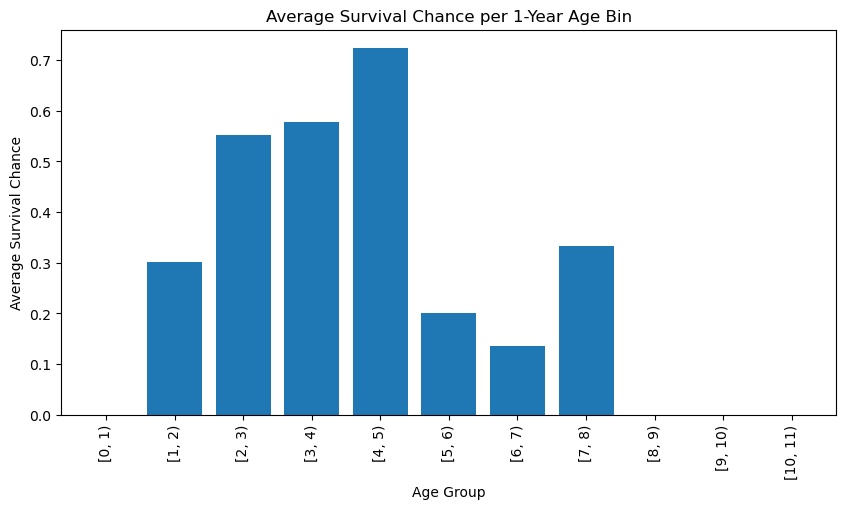

In [ ]:
# Convert Series to DataFrame
df = FS_n[1].reset_index()
df.columns = ["Age", "SurvivalChance"]

# Choose bin size (e.g., 10 years)
bin_size = 1
bins = range(0, int(df["Age"].max()) + bin_size, bin_size)

# Cut ages into bins and compute mean survival chance
df["AgeBin"] = pd.cut(df["Age"], bins=bins, right=False)
survival_by_bin = df.groupby("AgeBin")["SurvivalChance"].mean()

# Plot histogram (bar chart of averages per bin)
plt.figure(figsize=(10,5))
survival_by_bin.plot(kind="bar", width=0.8)
plt.xlabel("Age Group")
plt.ylabel("Average Survival Chance")
plt.title(f"Average Survival Chance per {bin_size}-Year Age Bin")
plt.show()


In [ ]:
# Oefening: voeg je eigen EDA toe
# Gebruik Seaborn in plaats van Matplotlib.
# TODO: tel bijvoorbeeld overlevingspercentage per Pclass, Embarked, Fare-quantiles (pd.qcut), etc.

## 6. Feature Engineering

Voeg hier zelf extra features toe (bijv. `Title` uit `Name`, `FamilySize = SibSp + Parch + 1`, indicatoren, etc.).

Zorg wel dat het relevant is voor je eigen onderzoek. Waar ligt je eigen focus.

In [ ]:
# Je kan nu zelf features aanmaken invullen. 
train['FamilySize'] = train['SibSp'] + train['Parch'] + 1

print(train['FamilySize'])
FS_n = pd.crosstab(train['FamilySize'], train['Survived'], normalize='index')


''' 
# maak een dictionaries van Sex en Embarked
dict_Embarked = {'S':0, 'C':1, 'Q':2} 
dict_Sex = {"male": 0, "female": 1}
dict_Pclass = {1:0, 2:1, 3:2}

# drop missing values of column 'Embarked'
train = train.dropna(subset=['Embarked'])

# maak nieuwe kolommen voor sex en Embarked
train['Embarked_int'] = train['Embarked'].map(dict_Embarked)
train["Sex_int"] = train["Sex"].map(dict_Sex)
train['Pclass_0'] = train['Pclass'].map(dict_Pclass)

train = train.dropna(subset=['Embarked'])
'''

0      2
1      2
2      1
3      2
4      1
      ..
886    1
887    1
888    4
889    1
890    1
Name: FamilySize, Length: 889, dtype: int64


## 7. Baseline model — np.where invullen

In [108]:
# === 3. Regelgebaseerde baseline met np.where ===
# Regel: vrouwen overleven altijd, jongens (<10 jaar) ook, anders niet
#train_pred = np.where(
#    (train['Sex'] == 'female') | ((train['Sex'] == 'male') & (train['Age'] < 10)),
#    1, 0
#)

### MODEL
# += log(p,c)

'''
DataFrame SurvivalProbability

index = personID   pPclass  pSex  pEmbarked  pTotal

hier gaan we eerst p per persoon bepalen

returnen:
persoonID
pPclass
pSex
pEmbarked
pTotal

pTotal = log(pPclass) + log(pSex) + log(pEmbarked)  // scaled or calculated odds = np.exp(logP_survive - logP_die)  prob_survive = odds / (1 + odds)   // 
pTotal = pPclass * pSex * pEmbarked


?pTotalScaled?

'''

def lookup_probability(index, value): # index = Sex, Pclass, Embarked
    feature_rows = Survival_rates_lookup.loc[index]
    row = feature_rows[feature_rows['bin'].apply(lambda x: value in x)]

    if not row.empty:
        if row['prob'].iloc[0] <= 1e-3:
            return 1e-3
        else:
            return row['prob'].iloc[0]
    else:
        return survival_rate



SurvivalProbability = pd.DataFrame(index=train.index)
SurvivalProbability['pAge'] = train['Age'].apply(lambda v: lookup_probability('Age', v))
SurvivalProbability['pFare'] = train['Fare'].apply(lambda v: lookup_probability('Fare', v))
SurvivalProbability['pSex'] = train['Sex_int'].apply(lambda v: lookup_probability('Sex_int', v))
SurvivalProbability['pSibSp'] = train['SibSp'].apply(lambda v: lookup_probability('SibSp', v))
SurvivalProbability['pParch'] = train['Parch'].apply(lambda v: lookup_probability('Parch', v))
SurvivalProbability['pEmbarked'] = train['Embarked_int'].apply(lambda v: lookup_probability('Embarked_int', v))
SurvivalProbability['pPclass'] = train['Pclass_0'].apply(lambda v: lookup_probability('Pclass_0', v))


e:\Anaconda\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


PassengerId
892     0.010262
893     0.144496
894     0.016209
895     0.006137
896     0.776341
          ...   
1305    0.008174
1306    2.317355
1307    0.007922
1308    0.005997
1309    0.245986
Name: pTotal, Length: 418, dtype: float64
0.37


e:\Anaconda\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


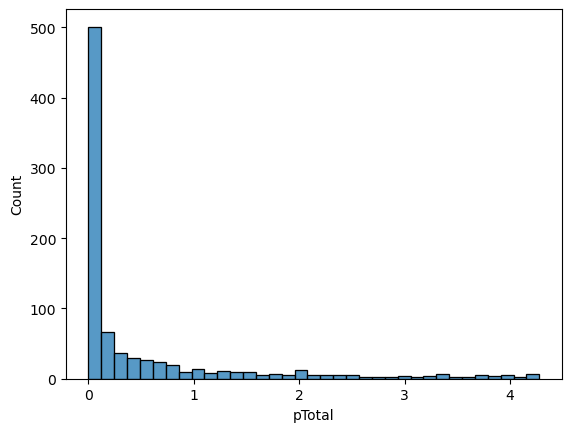

In [ ]:
SurvivalProbability['pSurvive'] = np.log(SurvivalProbability['pAge']) + np.log(SurvivalProbability['pFare']) + np.log(SurvivalProbability['pSex']) + np.log(SurvivalProbability['pSibSp']) + np.log(SurvivalProbability['pParch']) + np.log(SurvivalProbability['pEmbarked']) + np.log(SurvivalProbability['pPclass'])
SurvivalProbability['pDie'] = np.log(1 - SurvivalProbability['pAge']) + np.log(1 - SurvivalProbability['pFare']) + np.log(1 - SurvivalProbability['pSex']) + np.log(1 - SurvivalProbability['pSibSp']) + np.log(1 - SurvivalProbability['pParch']) + np.log(1 - SurvivalProbability['pEmbarked']) + np.log(1 - SurvivalProbability['pPclass'])

SurvivalProbability['pTotal'] = np.exp(SurvivalProbability['pSurvive'] - SurvivalProbability['pDie']) / (1 + np.exp(SurvivalProbability['pSurvive'] - SurvivalProbability['pDie']))
scale_factor = survival_rate / SurvivalProbability['pTotal'].mean()
SurvivalProbability['pTotal'] = SurvivalProbability['pTotal'] * 4.9

#print(scale_factor)

sns.histplot(x=SurvivalProbability['pTotal'])

#print(SurvivalProbability[SurvivalProbability['pTotal'] > 0.5].value_counts().sum() / SurvivalProbability[SurvivalProbability['pTotal'] < 0.5].value_counts().sum())


SurvivalTest = pd.DataFrame(index=test.index)
SurvivalTest['pAge'] = test['Age'].apply(lambda v: lookup_probability('Age', v))
SurvivalTest['pFare'] = test['Fare'].apply(lambda v: lookup_probability('Fare', v))
SurvivalTest['pSex'] = test['Sex_int'].apply(lambda v: lookup_probability('Sex_int', v))
SurvivalTest['pSibSp'] = test['SibSp'].apply(lambda v: lookup_probability('SibSp', v)) 
SurvivalTest['pParch'] = test['Parch'].apply(lambda v: lookup_probability('Parch', v))
SurvivalTest['pEmbarked'] = test['Embarked_int'].apply(lambda v: lookup_probability('Embarked_int', v))
SurvivalTest['pPclass'] = test['Pclass_0'].apply(lambda v: lookup_probability('Pclass_0', v))


SurvivalTest['pSurvive'] = np.log(SurvivalTest['pAge']) + np.log(SurvivalTest['pFare']) + np.log(SurvivalTest['pSex']) + np.log(SurvivalTest['pSibSp']) + np.log(SurvivalTest['pParch']) + np.log(SurvivalTest['pEmbarked']) + np.log(SurvivalTest['pPclass'])
SurvivalTest['pDie'] = np.log(1 - SurvivalTest['pAge']) + np.log(1 - SurvivalTest['pFare']) + np.log(1 - SurvivalTest['pSex']) + np.log(1 - SurvivalTest['pSibSp']) + np.log(1 - SurvivalTest['pParch']) + np.log(1 - SurvivalTest['pEmbarked']) + np.log(1 - SurvivalTest['pPclass'])

SurvivalTest['pTotal'] = np.exp(SurvivalTest['pSurvive'] - SurvivalTest['pDie']) / (1 + np.exp(SurvivalTest['pSurvive'] - SurvivalTest['pDie']))
scale_factor = survival_rate / SurvivalTest['pTotal'].mean()
SurvivalTest['pTotal'] = SurvivalTest['pTotal'] * 4.9


print(SurvivalTest['pTotal'])

print(SurvivalTest[SurvivalTest['pTotal'] > 0.5].value_counts().sum() / SurvivalTest[SurvivalTest['pTotal'] < 0.5].value_counts().sum())

## 8. Maak een eindmodel op volledige trainingsdata en voorspel op test

Hier kiezen we als voorbeeld het np.where model (of gebruik anders een ander model).


In [177]:
# === Toepassen op testset ===

#submission = pd.DataFrame({
#    'PassengerId': test['PassengerId'],
#    'Survived': test_pred.astype(int)
#})

submission = pd.DataFrame({
    'PassengerId' : SurvivalTest.index,
    'Survived' : (SurvivalTest['pTotal'] > 0.5).astype(int)
})


submission.to_csv("submission.csv", index=False)
print("submission.csv aangemaakt!")
submission.head()

submission.csv aangemaakt!


,PassengerId,Survived
PassengerId,,
892,892,0
893,893,0
894,894,0
895,895,0
896,896,1


## 9. Checklist & Volgende stappen

- [ ] Zorg dat er een duidelijke samenhang is tussen de grafieken -> Feature Engineering -> je uiteindelijke model! Dat is het belangrijkst.
- [ ] Laat geen grafieken zien waar je niks mee doet tijdens de presentatie.
- [ ] Zorg dat er dus een rode draad is in je verhaal. 

Voorbeeld: We hebben de focus gelegd op leeftijd -> EDA laat deze grafieken met leeftijd zien. We hebben met Feature Engineering nog leeftijdsgroepen aangemaakt -> We hebben in het model de leeftijden gebruikt. Dit is onze score.

- [ ] Eventueel EDA (een klein beetje) uitbreiden (meer grafieken, correlaties, outliers)
- [ ] Feature engineering verbeteren (wat is er relevant?)
- [ ] Meer modellen proberen (Logistic Regression? Sklearn)
- [ ] Submission inleveren op kaggle en kijken hoe goed je score is

Succes met de case!